In [1]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from scipy.stats import norm
#from scipy.stats import ecdf -- dees lukt ni

import sys
sys.path.append('..')


MASTER_DATA_LOCATION = os.path.join('..', 'data', 'input', 'master_data.json')
PLANT_DATA_DIRECTORY = os.path.join('..', 'data', 'input', 'daily_production')
PRODUCTION_PLANT = 'STO'
NBR_DAYS_PRODUCTION_SIMULATION = 7


## Read the data

In [2]:
## Read the data

def read_master_data (file_path): 
    with open(file_path, 'r') as file:
        file_contents = json.load(file)
    return file_contents 

def read_production_plant_data (plant_production_data_file_path, production_plant): 
    data_list = []
    # Iterate over each file in the directory, read the data and append it to the data_list
    directory = os.path.join(plant_production_data_file_path, production_plant)
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                json_data = json.load(file)
                data_list.append(json_data)
    # Convert the list of dictionaries into a DataFrame
    df_production_data = pd.DataFrame(data_list)
    return df_production_data


                

master_data = read_master_data(MASTER_DATA_LOCATION)

# READ BRU production data

df = read_production_plant_data(PLANT_DATA_DIRECTORY, PRODUCTION_PLANT)
df['plant_name'] = PRODUCTION_PLANT


# Not interested in the days with maintenanc
df = df[df['maintenance'] == 'No'].drop('maintenance', axis=1)




## plot a sample of the production data

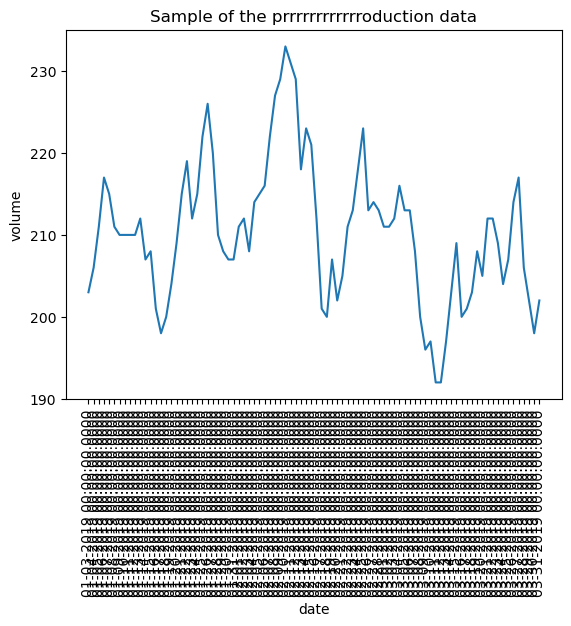

In [3]:
#Just plot a sample of the data
# Define the specific period
start_date = '01-03-2019'
end_date = '31-03-2019'

df['only_date'] = df['date'].str[:10]
df['date_obj'] = pd.to_datetime(df['date'].str[:10], format='%m-%d-%Y')

#Filter the DataFrame for entries within the specific period
filtered_df = df[(df['date_obj'] >= start_date) & (df['date_obj'] <= end_date)]

# Plot the graph
plt.plot(filtered_df['date'], filtered_df['production'])

# Add labels and title
plt.xlabel('date')
plt.ylabel('volume')
plt.title('Sample of the prrrrrrrrrrrroduction data')
plt.xticks(rotation=90)

# Show the plot
plt.show()



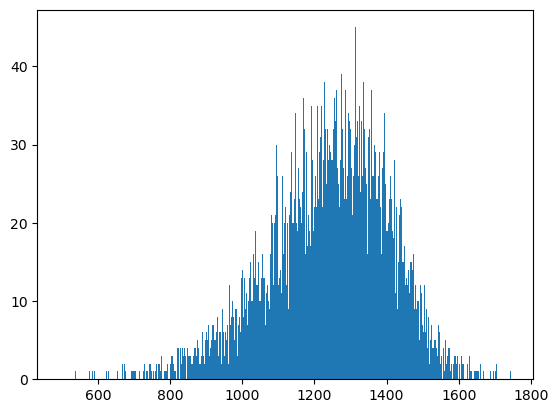

In [4]:
perc_0 = df[df['production'] <= 0.05].production.count() / df.production.count()
mu, sigma = norm.fit(df[df['production'] >= 0.05].production.astype(int))

def model(perc_0, avg, std, size):
    cumul = 0
    for _ in range (size) : 
        if np.random.rand() < perc_0:
            cumul += 0
        else:
            cumul += np.random.normal(loc = avg, scale = std)
    return cumul


def production_simulation(nbr_days, avg, std, perc_0) :
    list_production = list()
    for _ in range (10**4) : 
        list_production.append(model(perc_0, avg, std, nbr_days))
    return list_production


simulated_production_data_n_days = production_simulation(NBR_DAYS_PRODUCTION_SIMULATION, mu, sigma, perc_0)
plt.hist(simulated_production_data_n_days, bins=1000);



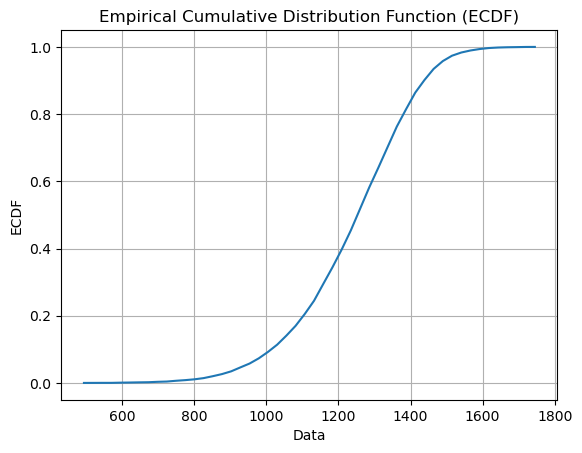

haas


In [5]:
# Compute ECDF
def ecdf(data, x_values):
    sorted_data = np.sort(data)
    n = len(data)
    y_values = np.searchsorted(sorted_data, x_values, side='right') / n
    return y_values

xx = np.linspace(min(simulated_production_data_n_days),max(simulated_production_data_n_days))
Fxx = ecdf(simulated_production_data_n_days, xx)





# Plot ECDF
plt.plot(xx, Fxx)
plt.xlabel('Data')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function (ECDF)')
plt.grid(True)
plt.show()

print("haas")


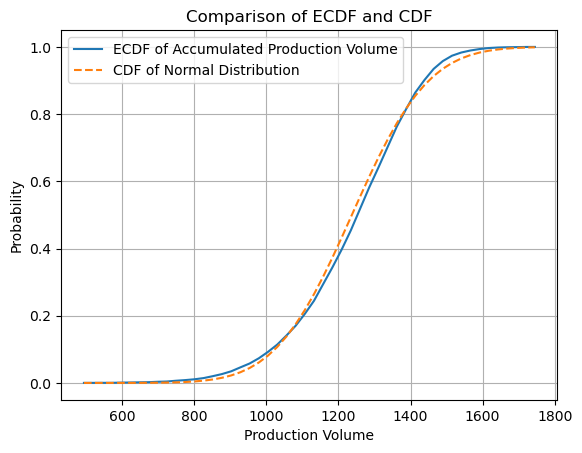

In [6]:
#Compute the CDF of the theoretical normal distribution
mean_volume = np.mean(simulated_production_data_n_days)
std_dev_volume = np.std(simulated_production_data_n_days)
#x_cdf = np.linspace(min(simulated_production_data_n_days), max(simulated_production_data_n_days), 1000)
y_cdf = norm.cdf(xx, loc=mean_volume, scale=std_dev_volume)

plt.plot(xx, Fxx, label='ECDF of Accumulated Production Volume')
plt.plot(xx, y_cdf, label='CDF of Normal Distribution', linestyle='--')
plt.xlabel('Production Volume')
plt.ylabel('Probability')
plt.title('Comparison of ECDF and CDF')
plt.legend()
plt.grid(True)
plt.show()

1.2637174061887624
0.9934326799356272
0.8756725965611748
0.6823700441721364
0.515803911866152
0.6097976590266114
0.4566037592386683
0.46741473053018623
0.3707554262680619
0.376240822288942
0.3811658235836615
0.3631652437103059
0.36845275230013497
0.31776856860002994
0.34083050218636307


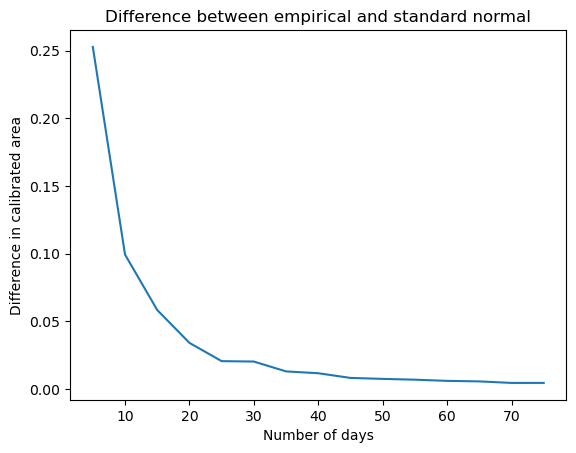

In [7]:
# check that the ecdf and cdf come closer when the number of days grows ; very time consuming 
from scipy.integrate import simps 

nauwkeurigheid = list()

for test_nr_of_days in range (5, 76, 5) :
    simulated_production_data_n_days = production_simulation(test_nr_of_days, mu, sigma, perc_0)
    xx = np.linspace(0,max(simulated_production_data_n_days))
    Fxx = ecdf(simulated_production_data_n_days, xx)
    mean_volume = np.mean(simulated_production_data_n_days)
    std_dev_volume = np.std(simulated_production_data_n_days)
    y_cdf = norm.cdf(xx, loc=mean_volume, scale=std_dev_volume)

    #plt.plot(xx, Fxx, label='ECDF of Accumulated Production Volume')
    #plt.plot(xx, y_cdf, label='CDF of Normal Distribution', linestyle='--')
    #plt.xlabel('Production Volume')
    #plt.ylabel('Probability')
    #plt.title('Comparison of ECDF and CDF')
    #plt.legend()
    #plt.grid(True)
    #plt.show()
    
    area = simps(np.abs(Fxx - y_cdf), xx)
    #reduce it to fit the same scale, let's define the 'max' - 'min' = 100 
    area = area * 100 / (max(simulated_production_data_n_days) - min(simulated_production_data_n_days))

    nauwkeurigheid.append([test_nr_of_days, area/test_nr_of_days])
    print(area)
    
df_nauwkeurigheid = pd.DataFrame(nauwkeurigheid, columns=['NumberOfDays', 'Difference'])

plt.plot(df_nauwkeurigheid.NumberOfDays, df_nauwkeurigheid.Difference)
plt.xlabel('Number of days')
plt.ylabel('Difference in calibrated area')
plt.title('Difference between empirical and standard normal')

plt.show()

In [8]:
mu

190.9679245283019